# Multimodal Prompt-to-Image Generation

To generate desired images using image generation models, it's crucial to accurately describe the image details in the prompt. However, creating detailed prompts without prior information can be challenging. To assist with this, we propose creative image prompt ideas based on user-provided styles and keywords through Multimodal LLM. This allows users to generate image prompts more intuitively and reduce the effort required for prompt writing.

The image generation model used is [Amazon Titan Image Generator G1 v2](https://aws.amazon.com/ko/blogs/korea/amazon-titan-image-generator-v2-is-now-available-in-amazon-bedrock/).

In [ ]:
import os
import sys

ROOT_PATH = os.path.abspath("../../")
sys.path.append(ROOT_PATH)

In [1]:
import re

from params import ImageParams
from aws.titan_image import BedrockTitanImage
from utils.images import display_image, encode_image_base64_from_file

from langchain.prompts import PromptTemplate
from typing import List
from aws.claude import BedrockClaude

image_params = ImageParams()
titanImageGen = BedrockTitanImage(
    region='us-west-2',
    modelId='amazon.titan-image-generator-v2:0'
)

keyword="olympic",
style="minimalist, simple, clean and abstract background image, and do not contain many patterns, logos, or letters."

## Basic Prompt


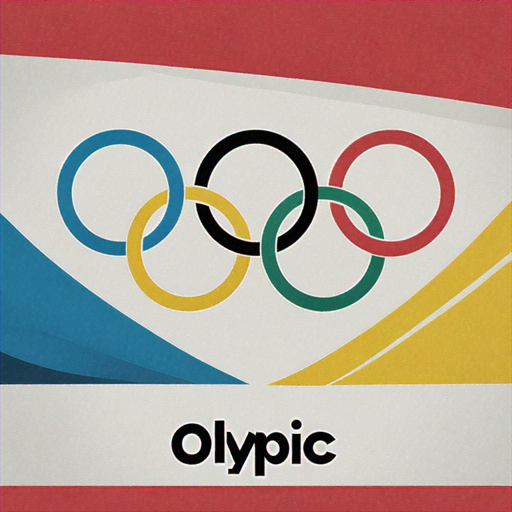

In [4]:
body = image_params.text_to_image(text=f"{keyword}, {style}")
img = titanImageGen.generate_image(body)
display_image(img)

## LLM Prompt

This is the result of generating prompts for Image Generation from LLM. When you input style and keyword values, it suggests 3 image prompts based on that information.

- `style`: desired mood or style
- `keyword`: keywords for the image you want to generate

In [2]:
PROMPT = """You are an Assistant that creates prompts for generate background image by image generator model. The image that Human wants is written in <keyword>.
Follow style guide in <style> and write three images creating prompts keeping it to 300 characters or less. Use this fomat without further explanation: 
<prompt>image prompt</prompt>

<keyword>
{keyword}
</keyword>

<style>
{style}
</style>
"""

def extract_format(result_string):
    pattern = r'<prompt>(.*?)</prompt>'
    return re.findall(pattern, result_string)

def get_prompt(keyword: str, style: str): 
    return PromptTemplate(
                template=PROMPT,
                input_variables=["keyword", "style"]
            ).format(keyword=keyword,
                     style=style)

def get_prompt_by_llm(prompt: str) -> List[str]:
    claude = BedrockClaude()
    res = claude.invoke_llm_response(prompt)
    return extract_format(res)

In [3]:
prompt = get_prompt(
    keyword=keyword,
    style=style
)

image_prompts = get_prompt_by_llm(prompt)
print(image_prompts)

['Minimalist abstract background with simple geometric shapes in Olympic ring colors - blue, yellow, black, green, and red - arranged in a clean, circular pattern on a white backdrop.', 'Clean, abstract representation of an Olympic torch silhouette against a gradient background, using subtle shades of gold and silver for a sleek, modern look.', 'Simple, stylized illustration of five interlocking rings in a minimalist style, using thin lines and negative space to create a contemporary Olympic-inspired design.']


Minimalist abstract background with simple geometric shapes in Olympic ring colors - blue, yellow, black, green, and red - arranged in a clean, circular pattern on a white backdrop.



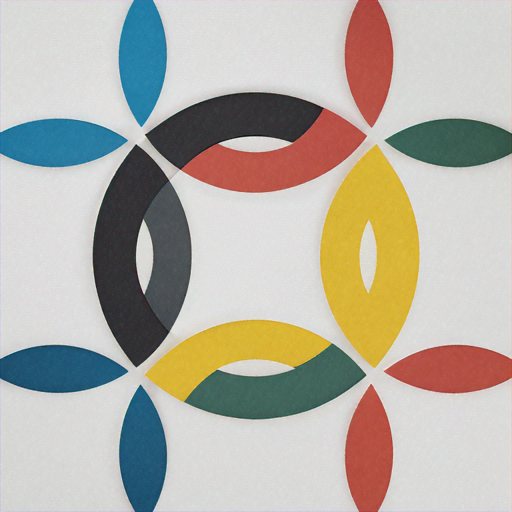

Clean, abstract representation of an Olympic torch silhouette against a gradient background, using subtle shades of gold and silver for a sleek, modern look.



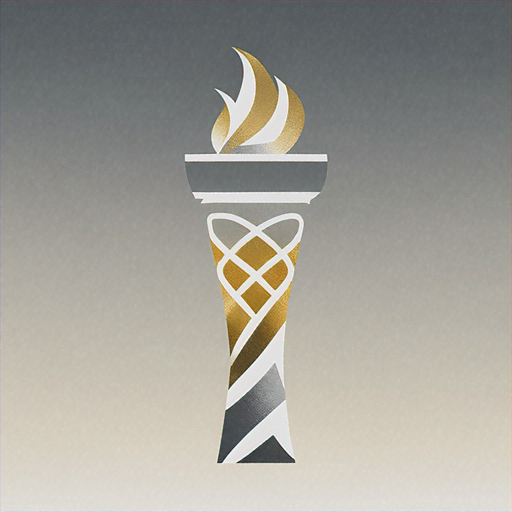

Simple, stylized illustration of five interlocking rings in a minimalist style, using thin lines and negative space to create a contemporary Olympic-inspired design.



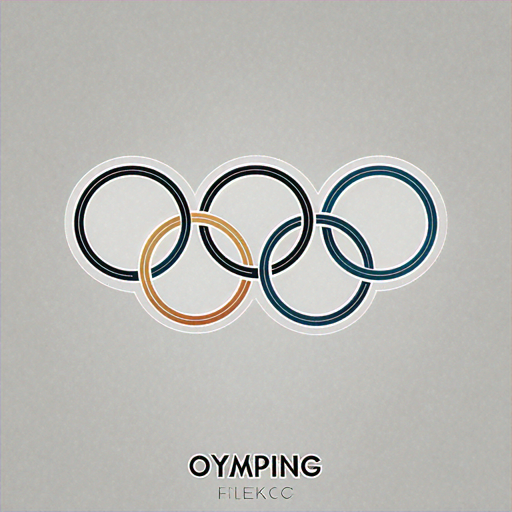

In [4]:
for prompt in image_prompts:
    print(prompt)
    body = image_params.text_to_image(text=prompt)
    img = titanImageGen.generate_image(body)
    display_image(img)

## Multimodal LLM Prompt

Titan Image Generator offers several options for creating new images based on reference images:

- **Image Conditioning**: Generates images that match the layout and composition of the reference image while following text prompts. This may be limited to simply reconstructing existing images, restricting creative freedom.

- **Color Guided Generation**: Reflects the color tone of the image by receiving reference colors through a reference image. While it reflects some color tones, it's difficult to reflect the mood or texture of the image.

- **Image Variation**: Generates images that preserve the source image but transform the style and background. The range of variation is limited and there are constraints on the original image.

While these methods are useful for reflecting specific attributes of reference images (such as color, layout, source image, etc.), they have limitations in generating completely new images that reflect creative and complex features due to the restricted range of variations. Using a Multimodal LLM to understand reference images and generate prompts for creating target images allows for more free and creative image prompt generation.


In [31]:
PROMPT = """You are an Assistant that creates prompts for generate background image by image generator model. The image that Human wants is written in <keyword>.
            Write a images three creation prompts keeping it to 300 characters or less to maintain the style of a given image. Use this fomat without further explanation:
            <prompt>image prompt</prompt>

            <keyword>
            {keyword}
            </keyword>
            """


def get_mm_prompt(keyword: str):
    return PromptTemplate(
                template=PROMPT,
                input_variables=["keyword"]
            ).format(keyword=keyword)

def get_prompt_by_mm_llm(prompt: str, image: str) -> List[str]:
    claude = BedrockClaude()
    res = claude.invoke_llm_response(text=prompt, image=image)
    return extract_format(res)


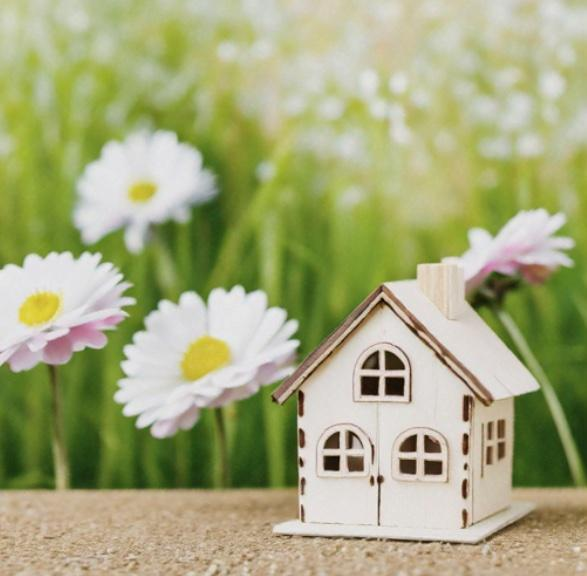

['Olympic village miniature houses nestled among giant daisies, soft focus background, dreamy atmosphere, macro photography', 'Tiny Olympic stadium model surrounded by oversized wildflowers, blurred green backdrop, whimsical scale contrast, tilt-shift effect', 'Miniature Olympic torch emerging from daisy petals, soft bokeh, ethereal lighting, fairytale-like setting, close-up shot']
Olympic village miniature houses nestled among giant daisies, soft focus background, dreamy atmosphere, macro photography



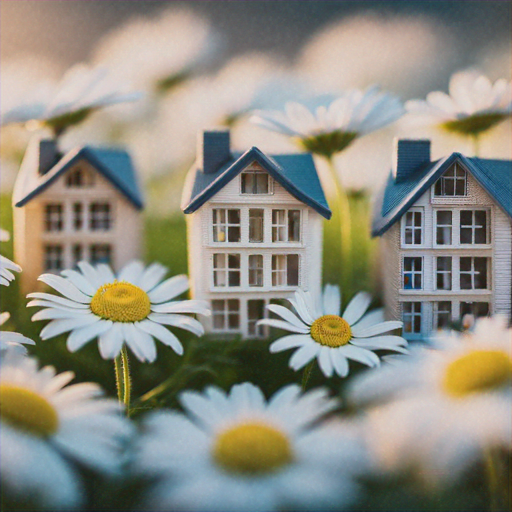

Tiny Olympic stadium model surrounded by oversized wildflowers, blurred green backdrop, whimsical scale contrast, tilt-shift effect



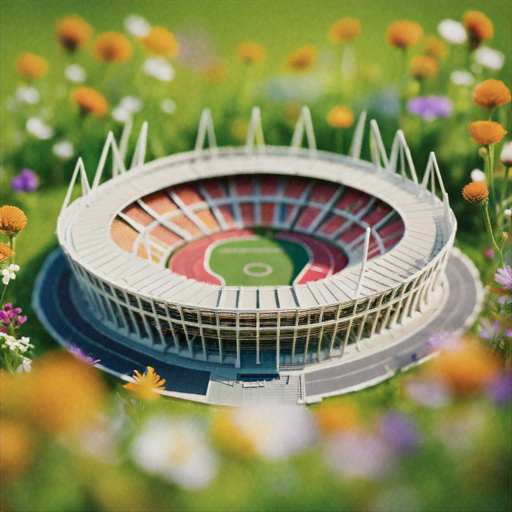

Miniature Olympic torch emerging from daisy petals, soft bokeh, ethereal lighting, fairytale-like setting, close-up shot



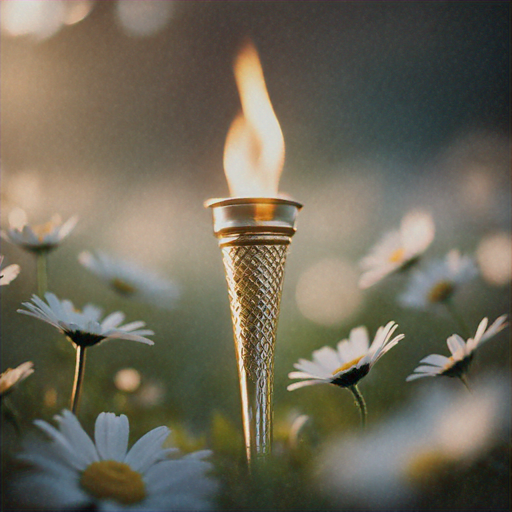

In [32]:
input_image = encode_image_base64_from_file(f"{ROOT_PATH}/sample/house.jpg", format="JPEG")
display_image(input_image)

prompt = get_mm_prompt(keyword=keyword)
image_prompts = get_prompt_by_mm_llm(prompt=prompt, image=input_image)
print(image_prompts)

for prompt in image_prompts:
    print(prompt)
    body = image_params.text_to_image(text=prompt)
    img = titanImageGen.generate_image(body)
    display_image(img)